In [66]:
import torch
torch.cuda.set_device(0)
test_batch_pool = [1, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
#out_features, in_features = 28672, 8192
out_features, in_features = 12288, 8192

In [67]:
import os,sys
from torch_int._CUDA import linear_a8_w8_b32_o32

@torch.no_grad()
def test_quant_linear_a8_w8_b8_o8(M,N,K):
    # Init inputs with corresponding shapes
    # Ref: https://github.com/Guangxuan-Xiao/torch-int/blob/main/torch_int/kernels/linear.cu#L369

    weight = torch.randint(-128, 127, (N, K), dtype=torch.int8).cuda()
    bias = torch.randint(torch.iinfo(torch.int32).min, torch.iinfo(
        torch.int32).max, (N,), dtype=torch.int32).cuda()
    x = torch.randint(-128, 127, (M, K), dtype=torch.int8).cuda()

    torch.cuda.synchronize()

    elapsed_time_ms = 0
    iterations = 30

    for _ in range(iterations):
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        torch.cuda.synchronize()
        start_event.record()
        y = linear_a8_w8_b32_o32(x, weight, bias)
        end_event.record()
        torch.cuda.synchronize()
        elapsed_time_ms += start_event.elapsed_time(end_event)

        #l2Flusher.flush(cuda.Stream(0))

    total_ops = M * N * K * 2 * iterations
    gflops = total_ops / elapsed_time_ms / 10**9
    return gflops, elapsed_time_ms

w8a8_flops = []
for m in test_batch_pool:
    gflops, elapsed_time_ms = test_quant_linear_a8_w8_b8_o8(m, out_features, in_features)
    w8a8_flops.append(gflops)



In [68]:
import torch
from awq_inference_engine import gemv_forward_cuda

@torch.no_grad()
def test_quant_linear_a16_w4_gemv(M, N, K):
    groupSize = 128

    # Init inputs with corresponding shapes
    # Ref: https://github.com/mit-han-lab/llm-awq/blob/main/awq/kernels/csrc/quantization/gemv_cuda.cu#L189

    x = torch.rand(M, K, dtype=torch.float16, device='cuda')
    weight = torch.randint(0, 128, (N, K // 8), dtype=torch.int32, device='cuda')
    scailing = torch.rand(N, K // groupSize, dtype=torch.float16, device='cuda')
    zeros = torch.randint(0,128,(N, K // groupSize // 8), dtype=torch.int32, device='cuda')
    
    elapsed_time_ms = 0
    iterations = 30

    for _ in range(iterations):
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        torch.cuda.synchronize()
        start_event.record()
        y = gemv_forward_cuda(x, weight, scailing, zeros, groupSize)
        end_event.record()
        torch.cuda.synchronize()
        elapsed_time_ms += start_event.elapsed_time(end_event)

        #l2Flusher.flush(cuda.Stream(0))

    total_ops = M * N * K * 2 * iterations
    gflops = total_ops / elapsed_time_ms / 10**9
    return gflops, elapsed_time_ms

a16w4_flops = []
for m in test_batch_pool:
    gflops, elapsed_time_ms = test_quant_linear_a16_w4_gemv(m, out_features, in_features)
    a16w4_flops.append(gflops)




In [69]:
import torch
sys.path.append('/home/chenyidong/SC/MixQ/src')
import mixlib
from awq_inference_engine import gemv_forward_cuda
arch = torch.cuda.get_device_capability()[0]

from mixquant.Cache import MixLibCache, MLPCache

cache = MixLibCache(512)   


@torch.no_grad()
def test_quant_linear_Mixq_gemm(M, N, K):
 
    x = torch.rand(M, K, dtype=torch.float16, device='cuda')
    q_weight = torch.randint(0, 128, (N, K  ), dtype=torch.int32, device='cuda').to(torch.int8)
    scailing = torch.rand(N, K  , dtype=torch.float16, device='cuda')
    zeros = torch.zeros(M, N  , dtype=torch.float16, device='cuda')
    scale_col = torch.rand(1, N  , dtype=torch.float16, device='cuda')
    x_scale = torch.rand(M, 1  , dtype=torch.float16, device='cuda')
    #q_xcache = torch.zeros(M, N  , dtype=torch.float16, device='cuda').to(torch.int8)
    elapsed_time_ms = 0
    iterations = 100

    for _ in range(iterations):
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        torch.cuda.synchronize()
        start_event.record()

        q_xcache = mixlib.FindRowScale(x,x_scale, M, K)
        if arch == 9:
            y = mixlib.gemm(q_xcache,q_weight,M, N, K)

            y1 = mixlib.dequantizeInt8(y, x_scale, scale_col, zeros, 8, M, N)
                

        else:


            y1 = mixlib.int8FusedDequantize(q_xcache, 
                                                    q_weight, 
                                                    x_scale,
                                                    scale_col,
                                                    zeros,
                                                    M,N,K)  

        end_event.record()
        torch.cuda.synchronize()
        elapsed_time_ms += start_event.elapsed_time(end_event)

        #l2Flusher.flush(cuda.Stream(0))

    total_ops = M * N * K * 2 * iterations
    gflops = total_ops / elapsed_time_ms / 10**9
    return gflops, elapsed_time_ms

w8a8o16_flops_quant = []
for m in test_batch_pool:
    gflops, elapsed_time_ms = test_quant_linear_Mixq_gemm(m, out_features, in_features )
    w8a8o16_flops_quant.append(gflops)




In [70]:
import torch
sys.path.append('/home/chenyidong/SC/MixQ/src')
import mixlib
from awq_inference_engine import gemv_forward_cuda
arch = torch.cuda.get_device_capability()[0]

from mixquant.Cache import MixLibCache, MLPCache

cache = MixLibCache(512)   


@torch.no_grad()
def test_quant_linear_Mixq_gemm(M, N, K):
 
    x = torch.rand(M, K, dtype=torch.float16, device='cuda')
    q_weight = torch.randint(0, 128, (N, K  ), dtype=torch.int32, device='cuda').to(torch.int8)
    scailing = torch.rand(N, K  , dtype=torch.float16, device='cuda')
    zeros = torch.zeros(M, N  , dtype=torch.float16, device='cuda')
    scale_col = torch.rand(1, N  , dtype=torch.float16, device='cuda')
    x_scale = torch.rand(M, 1  , dtype=torch.float16, device='cuda')
    q_xcache = torch.zeros(M, N  , dtype=torch.float16, device='cuda').to(torch.int8)
    elapsed_time_ms = 0
    iterations = 100

    for _ in range(iterations):
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        torch.cuda.synchronize()
        start_event.record()

        if arch == 9:
            y = mixlib.gemm(q_xcache,q_weight,M, N, K)

            y1 = mixlib.dequantizeInt8(y, x_scale, scale_col, zeros, 8, M, N)
                

        else:


            y1 = mixlib.int8FusedDequantize(q_xcache, 
                                                    q_weight, 
                                                    x_scale,
                                                    scale_col,
                                                    zeros,
                                                    M,N,K)  

        end_event.record()
        torch.cuda.synchronize()
        elapsed_time_ms += start_event.elapsed_time(end_event)

        #l2Flusher.flush(cuda.Stream(0))

    total_ops = M * N * K * 2 * iterations
    gflops = total_ops / elapsed_time_ms / 10**9
    return gflops, elapsed_time_ms

w8a8o16_flops = []
for m in test_batch_pool:
    gflops, elapsed_time_ms = test_quant_linear_Mixq_gemm(m, out_features, in_features )
    w8a8o16_flops.append(gflops)




In [71]:
import torch
from torch.nn import functional as F

@torch.no_grad()
def test_quant_linear_a16_w16(M, N ,K) -> float:
    weight = torch.rand(N, K, dtype=torch.float16).cuda()
    x = torch.rand(M, K, dtype=torch.float16).cuda()

    elapsed_time_ms = 0
    iterations = 60
    
    for _ in range(iterations):
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        torch.cuda.synchronize()
        start_event.record()
        y = F.linear(x, weight)
        end_event.record()
        torch.cuda.synchronize()
        elapsed_time_ms += start_event.elapsed_time(end_event)

        #l2Flusher.flush(cuda.Stream(0))
    total_ops = M * N * K * 2 * iterations
    gflops = total_ops / elapsed_time_ms / 10**9
    return gflops, elapsed_time_ms

a16w16_flops = []
for m in test_batch_pool:
    gflops, elapsed_time_ms = test_quant_linear_a16_w16(m, out_features, in_features )
    a16w16_flops.append(gflops)




In [72]:
import torch
from torch.nn import functional as F

import bitsandbytes as bnb
from bitsandbytes.nn.modules import Linear8bitLt

@torch.no_grad()
def test_quant_linear_a16_w16(M, N ,K) -> float:
    weight = torch.rand(N, K, dtype=torch.float16).cuda()
    x = torch.rand(M, K, dtype=torch.float16).cuda()

    linear = torch.nn.Linear(K,N)
    linear_custom = Linear8bitLt(
        linear.in_features,
        linear.out_features,
        linear.bias is not None,
        has_fp16_weights=False,
        threshold=6.0,
    )
    linear_custom.weight = bnb.nn.Int8Params(
        linear.weight.data.clone(), requires_grad=False, has_fp16_weights=False
    ).to(linear.weight.dtype)
    linear_custom.bias = linear.bias
    linear_custom = linear_custom.cuda()
    
    elapsed_time_ms = 0
    iterations = 30
    
    for _ in range(iterations):
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        torch.cuda.synchronize()
        start_event.record()
        y =   linear_custom(x)
        end_event.record()
        torch.cuda.synchronize()
        elapsed_time_ms += start_event.elapsed_time(end_event)

        #l2Flusher.flush(cuda.Stream(0))
    total_ops = M * N * K * 2 * iterations
    gflops = total_ops / elapsed_time_ms / 10**9
    return gflops, elapsed_time_ms

llmint8 = []
for m in test_batch_pool:
    gflops, elapsed_time_ms = test_quant_linear_a16_w16(m, out_features, in_features )
    llmint8.append(gflops)



In [75]:
print("w8a8_flops = ",w8a8_flops)
print("a16w4_flops = ",a16w4_flops)
print("w8a8o16_flops_quant = ",w8a8o16_flops_quant)
print("w8a8o16_flops = ",w8a8o16_flops)
print("a16w16_flops = ",a16w16_flops)
print("llmint8 = ",llmint8)

w8a8_flops =  [1.5162570325573757, 12.071097357783414, 23.873284585674575, 46.814694417378675, 90.77488644765806, 171.49990004763524, 312.4026613756425, 371.4155836552251, 391.20315985871554, 396.95237576034293]
a16w4_flops =  [2.5336083399338567, 3.3885759692806725, 3.499141267263651, 3.4146918671724453, 3.3943347753965663, 3.37604454435574, 3.3598782125145745, 3.3653448385121854, 3.359921229330398, 3.3797898952587633]
w8a8o16_flops_quant =  [1.435199666084529, 11.713315633006577, 23.528257726768505, 46.884686672070615, 91.84607350811595, 177.63692960370494, 343.607640711516, 373.35248525088633, 363.0449738069455, 366.0217252991722]
w8a8o16_flops =  [1.5533538593376326, 12.928357764161289, 26.481421178220415, 53.01193123736556, 104.51791935083193, 204.21831955774138, 401.30479252636724, 440.09659916890337, 434.7179783641655, 443.04566134131676]
a16w16_flops =  [1.149754376688366, 9.05981427715246, 13.633485739787886, 35.55918016247522, 69.76799413093502, 128.5425726495709, 213.8918454

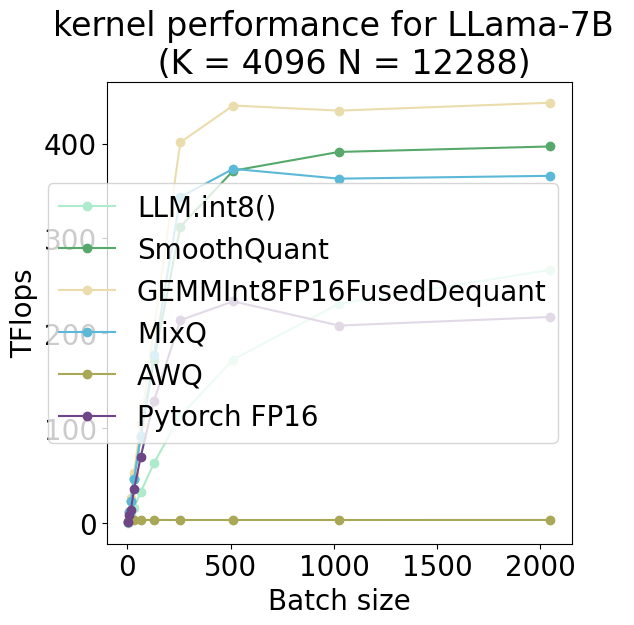

In [77]:
ai = [1,8, 16, 32, 64, 128, 256, 512, 1024, 2048]

w8a8_flops =  [1.5162570325573757, 12.071097357783414, 23.873284585674575, 46.814694417378675, 90.77488644765806, 171.49990004763524, 312.4026613756425, 371.4155836552251, 391.20315985871554, 396.95237576034293]
a16w4_flops =  [2.5336083399338567, 3.3885759692806725, 3.499141267263651, 3.4146918671724453, 3.3943347753965663, 3.37604454435574, 3.3598782125145745, 3.3653448385121854, 3.359921229330398, 3.3797898952587633]
w8a8o16_flops_quant =  [1.435199666084529, 11.713315633006577, 23.528257726768505, 46.884686672070615, 91.84607350811595, 177.63692960370494, 343.607640711516, 373.35248525088633, 363.0449738069455, 366.0217252991722]
w8a8o16_flops =  [1.5533538593376326, 12.928357764161289, 26.481421178220415, 53.01193123736556, 104.51791935083193, 204.21831955774138, 401.30479252636724, 440.09659916890337, 434.7179783641655, 443.04566134131676]
a16w16_flops =  [1.149754376688366, 9.05981427715246, 13.633485739787886, 35.55918016247522, 69.76799413093502, 128.5425726495709, 213.8918454891952, 233.76374499339911, 208.26675732560852, 217.2786300758353]
llmint8 =  [0.4893586618150922, 4.036089302076375, 8.18063797828092, 16.361275791452343, 32.68288791230077, 63.20424594417854, 113.13872652080607, 172.44740244523936, 231.1265016087222, 266.92879197184726]
import matplotlib.pyplot as plt
bar_colors_default = ["#5BB8D7", "#57A86B", "#A8A857", "#6E4587", "#ADEBCC", "#EBDCAD"]
# set font size
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(6, 6))

plt.plot(ai, llmint8, label='LLM.int8()', marker='o', color=bar_colors_default[4])
plt.plot(ai, w8a8_flops, label='SmoothQuant', marker='o', color=bar_colors_default[1])

plt.plot(ai, w8a8o16_flops, label='GEMMInt8FP16FusedDequant', marker='o', color=bar_colors_default[5])

plt.plot(ai, w8a8o16_flops_quant, label='MixQ', marker='o', color=bar_colors_default[0])

plt.plot(ai, a16w4_flops, label='AWQ', marker='o', color=bar_colors_default[2])
plt.plot(ai, a16w16_flops, label='Pytorch FP16', marker='o', color=bar_colors_default[3])

#plt.yscale('log', base=2)

plt.legend()
plt.xlabel('Batch size')
plt.ylabel('TFlops')
plt.title('kernel performance for LLama-13B \n (K = 8192 N = 12288)')
plt.show()
plt.close()

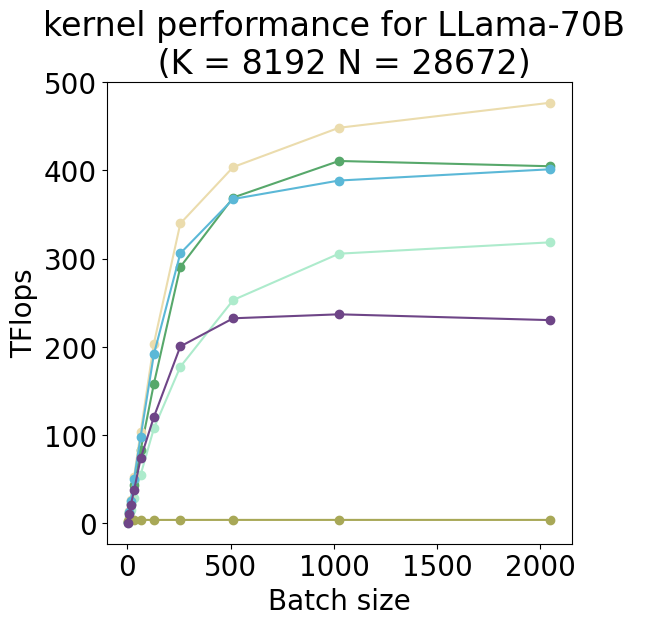

In [89]:
ai = [1,8, 16, 32, 64, 128, 256, 512, 1024, 2048]

w8a8_flops = [1.3867956695455728, 10.99904882516754, 21.77855820411885, 42.77706584779026, 82.65123143263274, 157.96382798142128, 290.52055173619493, 369.30676790262555, 410.76131298615894, 404.7888153196966]


a16w4_flops = [2.625440715594369, 3.2608837316706873, 3.4620614281923174, 3.4639403802504214, 3.4585542969614216, 3.4281927139636643, 3.4284128399899987, 3.4486368629263224, 3.4456090697080413, 3.43518446542782]

w8a8o16_flops = [1.6474018613291792, 13.299568794227012, 26.50405106710866, 52.455028057450555, 103.46817059572442, 203.55758263889297, 339.82613073352314, 403.87403797747606, 448.4430782845815, 476.8770653561462]

w8a8o16_flops_quant = [1.579289469527041, 12.75063756063459, 25.184532427762182, 49.623310203856725, 97.99448418953226, 191.42083662379548, 305.9143337004164, 367.6162005696006, 388.5702957795062, 401.36537555776914]

a16w16_flops = [0.24600600168788067, 10.012718632426553, 20.0108218407153, 37.02966658719694, 73.33576962729413, 120.29835002818803, 200.29684698958258, 232.2541329310434, 236.75467979580546, 230.15446619386358]

llmint8 = [0.2671748474223944, 6.802834781931645, 14.259555807784377, 28.197509489323746, 54.93993116759873, 107.28283876302687, 177.19263607103278, 252.95037653885683, 305.5489186904827, 318.44417860815156]
import matplotlib.pyplot as plt
bar_colors_default = ["#5BB8D7", "#57A86B", "#A8A857", "#6E4587", "#ADEBCC", "#EBDCAD"]
# set font size
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(6, 6))

plt.plot(ai, llmint8, label='LLM.int8()', marker='o', color=bar_colors_default[4])
plt.plot(ai, w8a8_flops, label='SmoothQuant', marker='o', color=bar_colors_default[1])

plt.plot(ai, w8a8o16_flops, label='GEMMInt8FP16FusedDequant', marker='o', color=bar_colors_default[5])

plt.plot(ai, w8a8o16_flops_quant, label='MixQ', marker='o', color=bar_colors_default[0])

plt.plot(ai, a16w4_flops, label='AWQ', marker='o', color=bar_colors_default[2])
plt.plot(ai, a16w16_flops, label='Pytorch FP16', marker='o', color=bar_colors_default[3])

#plt.yscale('log', base=2)

#plt.legend()
plt.xlabel('Batch size')
plt.ylabel('TFlops')
plt.title('kernel performance for LLama-70B \n (K = 8192 N = 28672)')
plt.show()
plt.close()

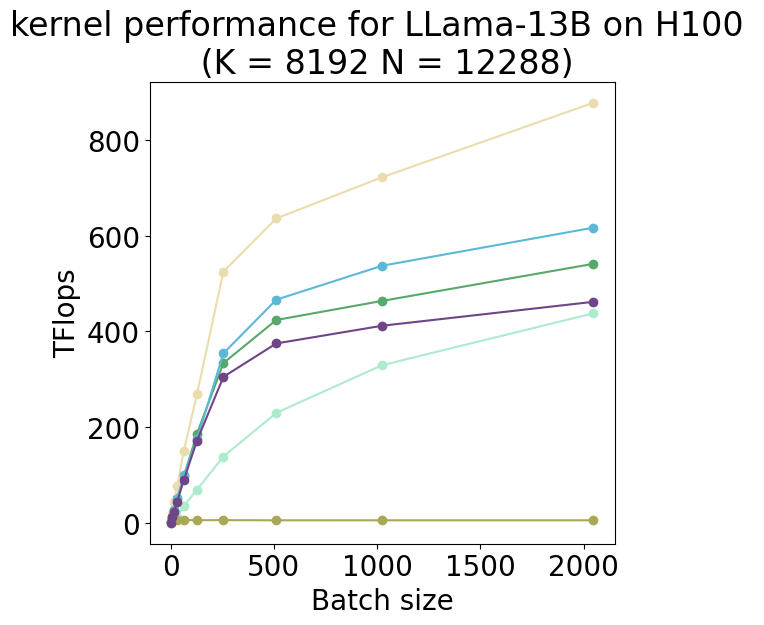

In [85]:
w8a8_flops =  [1.3590610512480625, 12.537880124215722, 26.080376010929374, 50.91247440892114, 96.87546531968987, 186.20661448882896, 333.89571120619524, 423.9588863797515, 463.78597075424193, 541.3915322989936]
a16w4_flops =  [3.5686080746463995, 4.93778328724235, 5.18059591541636, 5.313570812700941, 5.358618202402135, 5.396122626729688, 5.409157034102287, 5.103397353638181, 5.132015153811009, 5.156170019243311]
w8a8o16_flops_quant =  [1.5043736428352974, 12.41313144150349, 26.024367833663998, 50.175977054970666, 99.8628945255101, 174.49418422446013, 354.1357052280589, 466.34345851042696, 537.297615373212, 617.010558155727]
w8a8o16_flops =  [2.4977592822933374, 20.315252547731614, 44.02756135364901, 76.02106709962744, 150.2442862942806, 268.59482301654435, 525.2968699967905, 636.3015051830918, 722.3620467564056, 878.2050754966131]
a16w16_flops =  [0.053126641240842716, 11.54113240913536, 23.029458010428353, 44.1848053026665, 89.08519047930801, 171.73152493670008, 305.0807387318047, 374.87277086368294, 411.88454596889255, 461.93509793640175]
llmint8 =  [0.08735233497862858, 4.429290176596353, 9.094300447780467, 12.187257832039036, 35.17707225471087, 69.20163616972026, 138.468320719803, 229.7309042160843, 329.3804472702367, 437.93724274166505]

ai = [1,8, 16, 32, 64, 128, 256, 512, 1024, 2048]

import matplotlib.pyplot as plt
bar_colors_default = ["#5BB8D7", "#57A86B", "#A8A857", "#6E4587", "#ADEBCC", "#EBDCAD"]
# set font size
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(6, 6))

plt.plot(ai, llmint8, label='LLM.int8()', marker='o', color=bar_colors_default[4])
plt.plot(ai, w8a8_flops, label='SmoothQuant', marker='o', color=bar_colors_default[1])

plt.plot(ai, w8a8o16_flops, label='GEMMInt8FP16FusedDequant', marker='o', color=bar_colors_default[5])

plt.plot(ai, w8a8o16_flops_quant, label='MixQ', marker='o', color=bar_colors_default[0])

plt.plot(ai, a16w4_flops, label='AWQ', marker='o', color=bar_colors_default[2])
plt.plot(ai, a16w16_flops, label='Pytorch FP16', marker='o', color=bar_colors_default[3])

#plt.yscale('log', base=2)

#plt.legend()
plt.xlabel('Batch size')
plt.ylabel('TFlops')
plt.title('kernel performance for LLama-13B on H100 \n (K = 8192 N = 12288)')
plt.show()
plt.close()

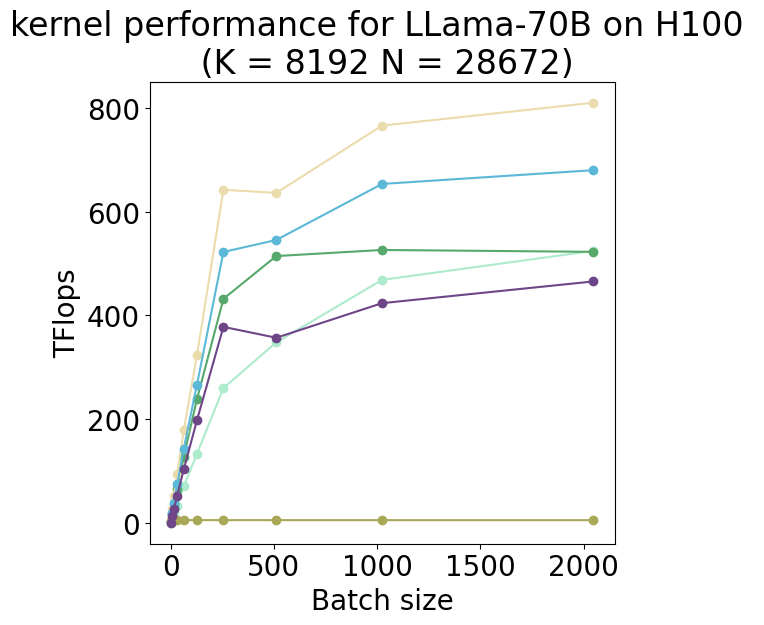

In [88]:
ai = [1,8, 16, 32, 64, 128, 256, 512, 1024, 2048]

w8a8_flops =  [1.9916615177056718, 17.051254054812073, 33.786168811484934, 65.82780782217723, 127.51174840416566, 238.58770732879623, 431.896220363955, 514.441713835063, 526.1918042804941, 522.5500079512312]
a16w4_flops =  [3.8021773139511486, 4.976192705055254, 5.328392980540899, 5.37951505465881, 5.162606065806706, 5.13208078874549, 5.121207649324683, 5.097260041768506, 5.08267515678935, 5.055664109648204]
w8a8o16_flops_quant =  [2.42770883897367, 19.603804502899923, 39.10440919063156, 73.9041382905233, 142.96602299615068, 266.51880510053485, 522.2857094432663, 545.4492695380408, 653.5109472595495, 680.0727332364354]
w8a8o16_flops =  [3.2987647579434443, 26.183482400223532, 52.09899437594109, 93.44556067467865, 178.54716304904767, 323.6931069598602, 642.2932561031831, 636.3286206371469, 765.9814269865714, 810.1733358279317]
a16w16_flops =  [0.11844378175957967, 13.254039847098866, 26.251903030665844, 52.35984402741255, 102.92281937358857, 198.05236213717515, 377.8538278664072, 356.8510338015455, 423.5864877705377, 465.50017898489756]
llmint8 =  [0.31887836946399306, 9.51255932836855, 19.08416822156103, 31.53596169937015, 70.49951275805131, 133.13446506341674, 259.7677921858163, 347.9769229822491, 468.45640898154295, 524.487617469455]

import matplotlib.pyplot as plt
bar_colors_default = ["#5BB8D7", "#57A86B", "#A8A857", "#6E4587", "#ADEBCC", "#EBDCAD"]
# set font size
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(6, 6))

plt.plot(ai, llmint8, label='LLM.int8()', marker='o', color=bar_colors_default[4])
plt.plot(ai, w8a8_flops, label='SmoothQuant', marker='o', color=bar_colors_default[1])

plt.plot(ai, w8a8o16_flops, label='GEMMInt8FP16FusedDequant', marker='o', color=bar_colors_default[5])

plt.plot(ai, w8a8o16_flops_quant, label='MixQ', marker='o', color=bar_colors_default[0])

plt.plot(ai, a16w4_flops, label='AWQ', marker='o', color=bar_colors_default[2])
plt.plot(ai, a16w16_flops, label='Pytorch FP16', marker='o', color=bar_colors_default[3])

#plt.yscale('log', base=2)

#plt.legend()
plt.xlabel('Batch size')
plt.ylabel('TFlops')
plt.title('kernel performance for LLama-70B on H100 \n (K = 8192 N = 28672)')
plt.show()
plt.close()